In [ ]:
from pathlib import Path

import matplotlib.pyplot as plt
from flow_analysis_comps.Fourier.OrientationSpaceManager import orientationSpaceManager
from util.video_io import read_video_metadata, load_tif_series_to_dask

import colorcet  # noqa: F401

%matplotlib widget

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
data_adr = Path(
    r"G:\AMOLF_Data\AMOLF-SHIMIZU Dropbox\Simon van Staalduine"
)  # Personal PC path
data_adr = Path(
    r"/Users/simonvanstaalduine/AMOLF-SHIMIZU Dropbox/Simon van Staalduine"
)  # Personal mac path
data_adr = Path(r"U:\test_data\20250122_Plate017")

plate_id = r"20250122_Plate017"
video_id = r"034"

total_path = data_adr / video_id / "Img"
info_path = total_path.parent / "videoInfo.txt"
# info_path = total_path / "videoInfo.json"

video_info = read_video_metadata(info_path)
array = load_tif_series_to_dask(total_path)  # Dims are z, y, x

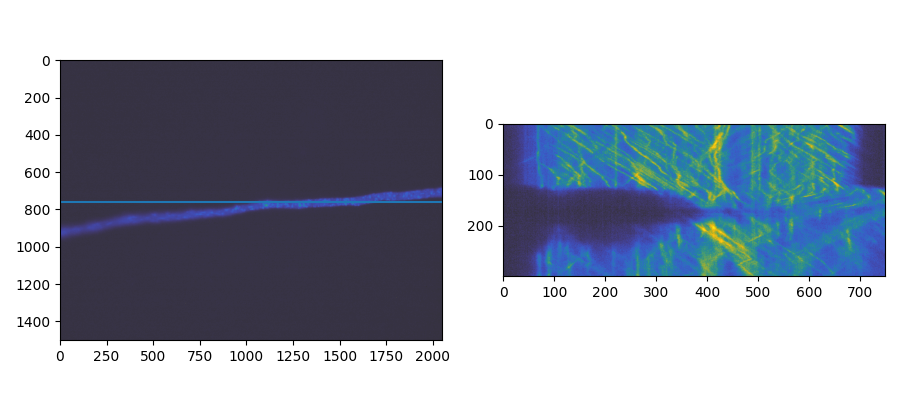

In [ ]:
line_height = 760
# Cutting out an image with (z,x) axes
img = array[:, line_height, 1000:1750].compute()

fig, ax = plt.subplots(1, 2, figsize=(9, 4))
ax[0].imshow(array[0, :, :], cmap="cet_CET_L20")
ax[0].axhline(line_height)

ax[1].imshow(img, cmap="cet_CET_L20")
ax[1].set_aspect("equal")
fig.tight_layout()

In [14]:
OSFilter = orientationSpaceManager(0.15, K=12)
img_fft = OSFilter.get_response(img)

Initiating filters on new image with dims (300, 750)


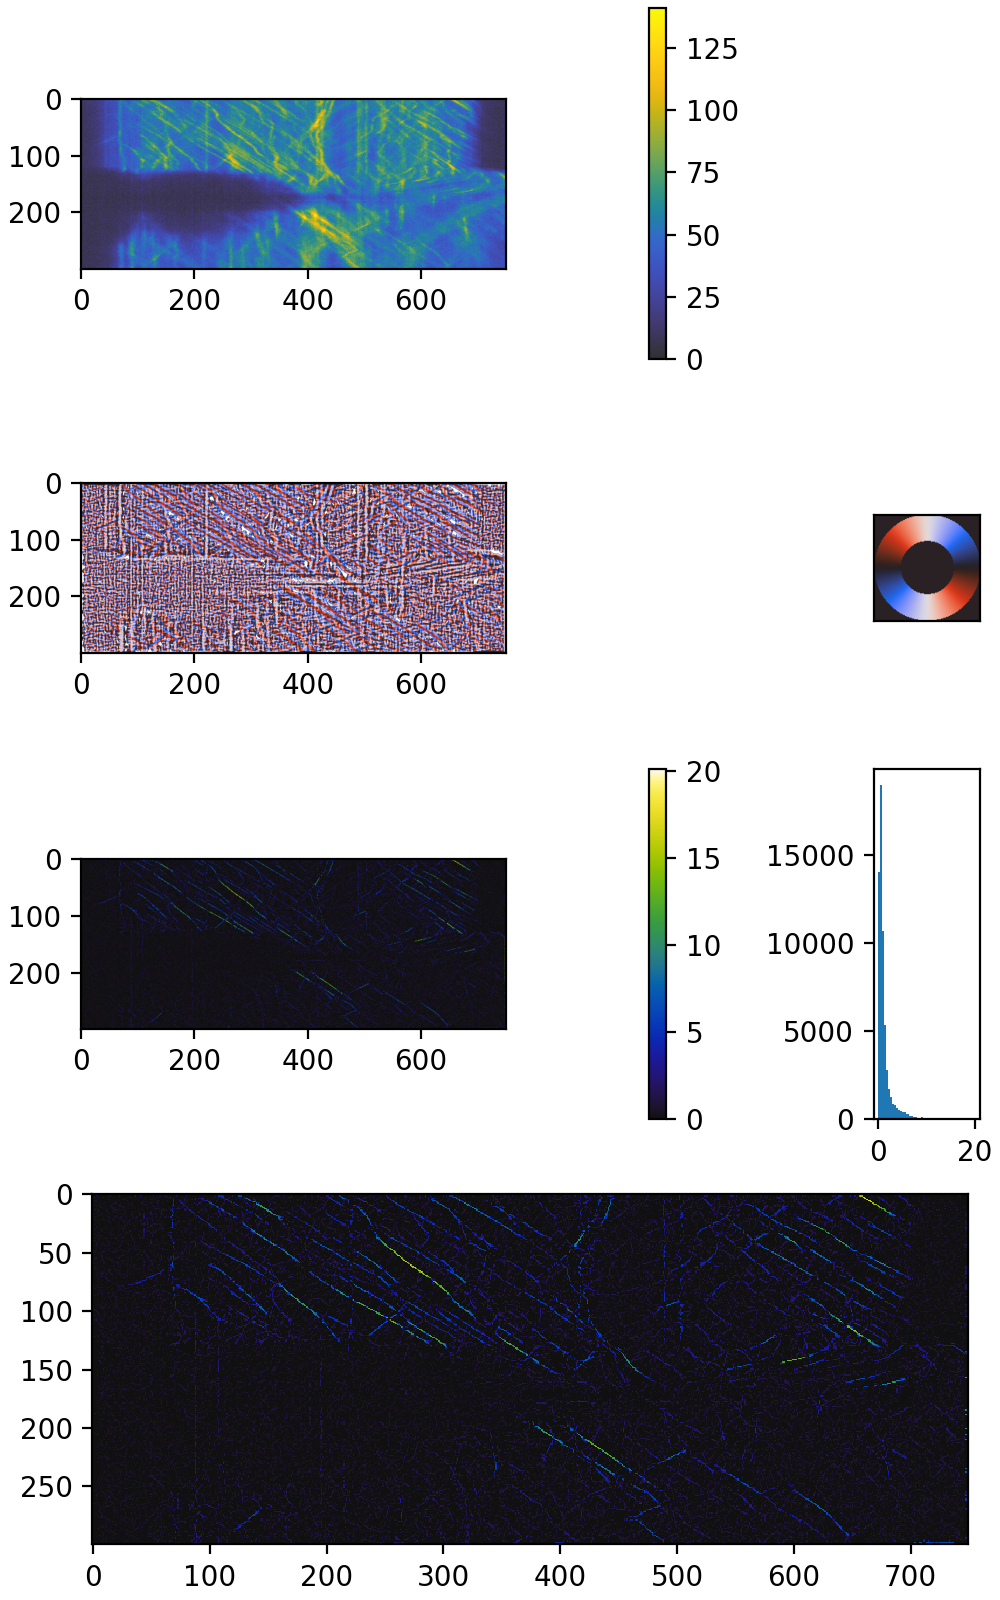

In [15]:
order = 12

OSFilter.demo_image(img, order=order, thresh_method="otsu")

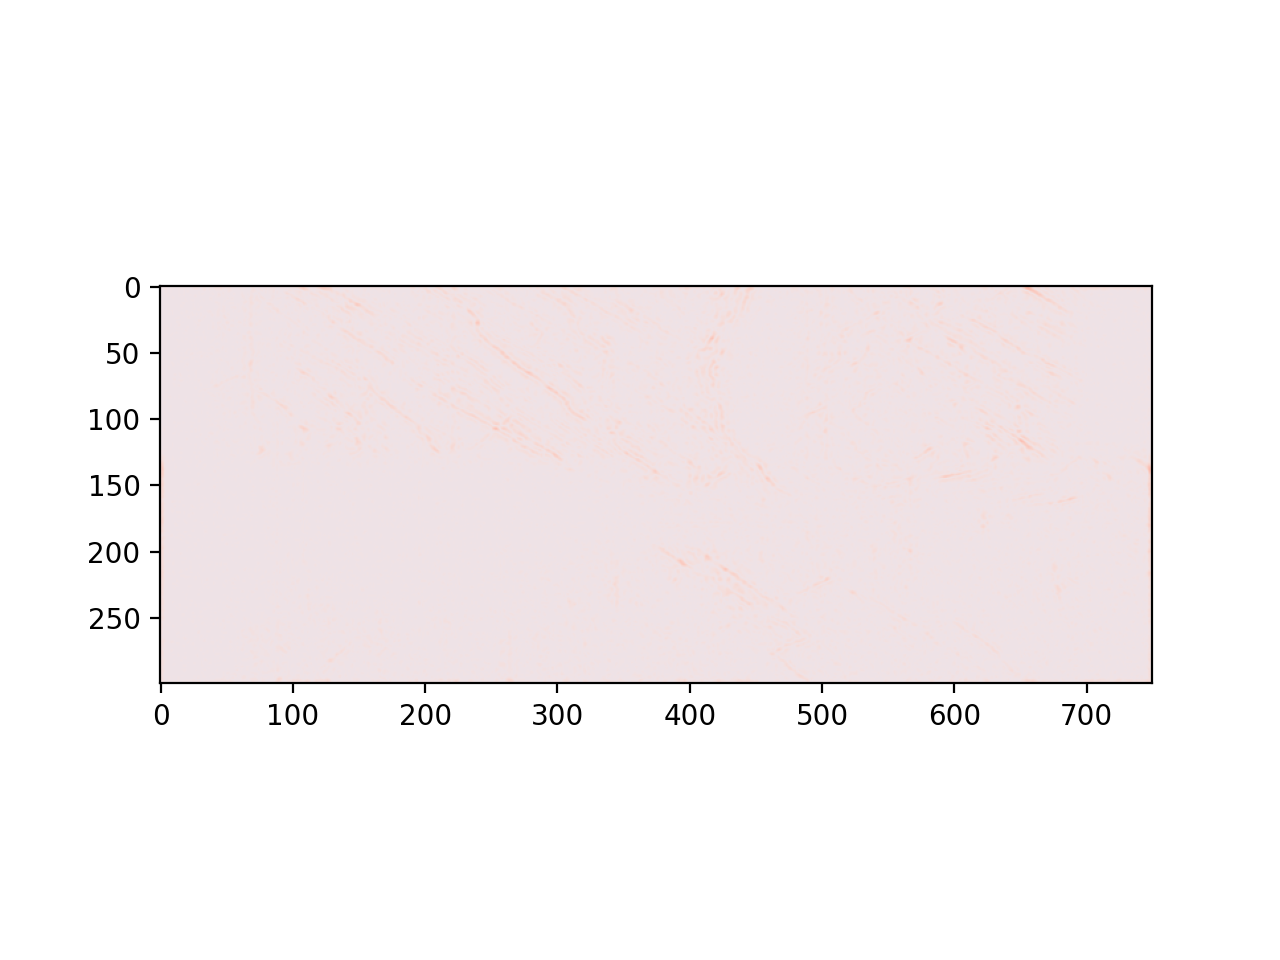

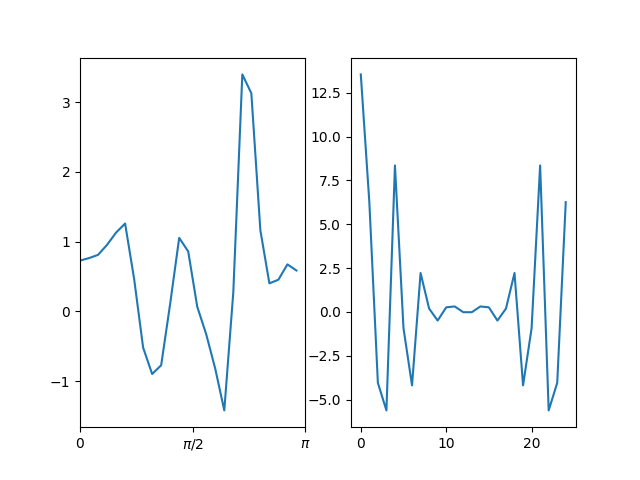

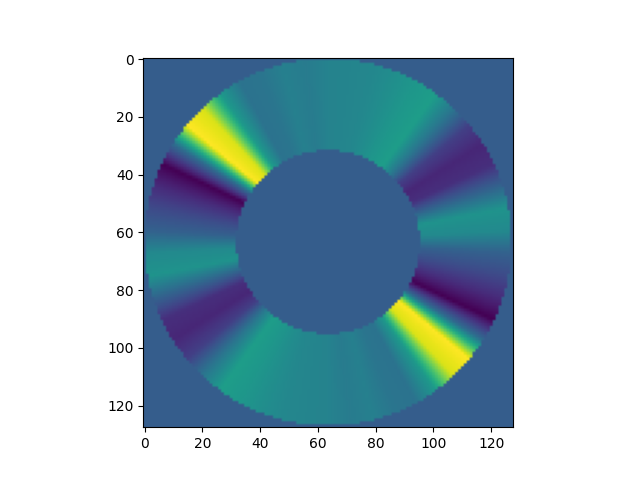

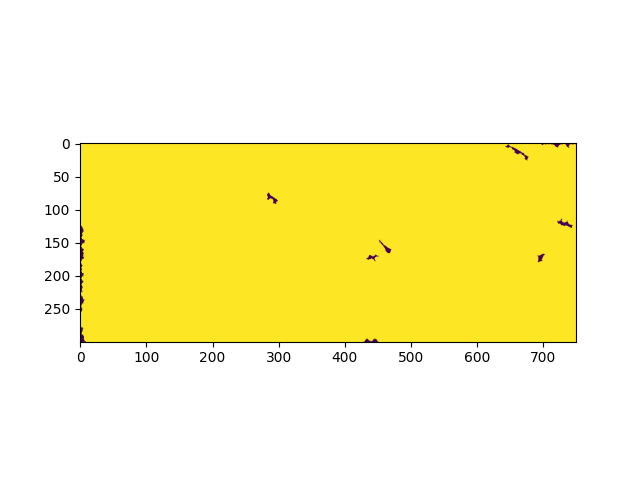

In [16]:
point = (384, 80)

fig = OSFilter.response.plot_mean_response()
thres = OSFilter.response.nlms_mask(fill_holes=True, thresh_method="otsu")
OSFilter.response.plot_lineof_point(point)
OSFilter.response.visualize_point_response(point)

fig, ax = plt.subplots()
ax.imshow(thres)